# Telecom Churn Notebook

# Introduction

**Business Info:** Interconnect is a telecom operator that provides two basic services:

- Landline communication. The telephone can be connected to several lines simultaneously.- 
Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cablees).

Additionally they provide:

- Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity).
  
- Support: A dedicated technical support line (TechSupport).
  
- Storage: Cloud file storage and data backup (OnlineBackup).
  
- Streaming: TV streaming (StreamingTV) and a movie directory (StreamingMovies).

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

**Business Problem:** Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

**Project Solution:** Develop a fast and accurate machine learning model that predicts whether a user is planning to leave.

**Project Plan:** 
1. Describe and clean dataset
  2. Create new features useful in predictive modeling
  3. Filter out unnecessary data
  4. Perform Exploratory Data Analysis
  5. Prepare Data for modeling
  6. Model data with machine learning models
  7. Tune hyperparameters of best model
  8. Study metrics to determine which model is most suitable for implementation

# Step 0: Imported Libraries and Functions

**Importing Libraries**

In [468]:
import pandas as pd
import numpy as np
import time as time
import joblib as joblib

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

**Useful Functions**

In [469]:
def evaluate_model(model, X, y):
    probabilities_valid = model.predict_proba(X)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(y, probabilities_one_valid)
    print('AUC - ROC Score:', auc_roc)
    
    fpr, tpr, thresholds = roc_curve(y, probabilities_one_valid)
    
    y_predictions = model.predict(X)
    accuracy = accuracy_score(y, y_predictions)
    print("Accuracy Score:", accuracy)
    
    recall = recall_score(y, y_predictions)
    print("Recall Score:", recall)
    precision = precision_score(y, y_predictions, zero_division=0)
    print("Precision Score:",precision)
    
    f1 = f1_score(y, y_predictions)
    print("F1 Score:", f1)
    
    confusion = confusion_matrix(y, y_predictions)
    print('Confusion Matrix:', confusion)
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    return auc_roc, accuracy, f1

In [470]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)

    return features_upsampled, target_upsampled

**Loading Files as DataFrames**

In [471]:
try:
    contract = pd.read_csv('final_provider/final_provider/contract.csv')
    personal = pd.read_csv('final_provider/final_provider/personal.csv')
    internet = pd.read_csv('final_provider/final_provider/internet.csv')
    phone = pd.read_csv('final_provider/final_provider/phone.csv')
except FileNotFoundError:
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')

# Step 1: Data Description and Cleaning

**Contract File**

In [472]:
print(contract.head())
print(contract.info())
print(contract.describe(include='all'))

   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Cou

In [473]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [474]:
print(f'Missing values: {contract.isna().sum()}')
print(f'Duplicated rows: {contract.duplicated().sum()}')

Missing values: customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64
Duplicated rows: 0


**Personal File**

In [475]:
print(personal.head())
print(personal.info())
print(personal.describe(include='all'))

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
        customerID gender  SeniorCitizen Partner Dependents
count         7043   7043    7043.000000    7043       7043
unique        7043      2            NaN       2          2
top     7590-VHVEG  

In [476]:
print(f'Missing values: {personal.isna().sum()}')
print(f'Duplicated rows: {personal.duplicated().sum()}')

Missing values: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Duplicated rows: 0


**Internet File**

In [477]:
print(internet.head())
print(internet.info())
print(internet.describe(include='all'))

   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   

In [478]:
print(f'Missing values: {internet.isna().sum()}')
print(f'Duplicated rows: {internet.duplicated().sum()}')

Missing values: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
Duplicated rows: 0


**Phone File**

In [479]:
print(phone.head())
print(phone.info())
print(phone.describe(include='all'))

   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390


In [480]:
print(f'Missing values: {phone.isna().sum()}')
print(f'Duplicated rows: {phone.duplicated().sum()}')

Missing values: customerID       0
MultipleLines    0
dtype: int64
Duplicated rows: 0


**Merging Files to Single DataFrame**

In [481]:
df = contract.merge(personal, on='customerID', how='outer')
df = df.merge(internet, on='customerID', how='outer')
df = df.merge(phone, on='customerID', how='outer')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [482]:
print(f'Missing Values: {df.isna().sum()}')

Missing Values: customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


In [483]:
df['InternetService'].fillna('None', inplace=True)
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
df.fillna('No', inplace=True)
print(f'Missing Values: {df.isna().sum()}')

Missing Values: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


**Description of Columns**

- **"customerID":** unique identifier assigned to each customer consisting of numbers and digits.
- **"BeginDate":** date customer started plan.
- **"EndDate":** date customer ended plan.
- **"Type":** length of time plan lasts (month-to-month, one year, etc.)
- **"PaperlessBilling":** whether customer opted out of receiving mailed bills.
- **"PaymentMethod":** means of payment.
- **"MonthlyCharges":** total amount paid per month.
- **"TotalCharges":** total aggregated sum paid since "BeginDate".
- **"gender":** gender of customer.
- **"SeniorCitizen":** whether customer is age 65 or older.
- **"Partner":** whether customer has a partner/spouse.
- **"Dependents":** whether customer has dependents.
- **"InternetService":** whether customer's plan includes internet service.
- **"OnlineSecurity":** whether customer's plan includes online security service.
- **"OnlineBackup":** whether customer's plan includes online backup service.
- **"DeviceProtection":** whether customer's plan includes online backup service.
- **"TechSupport":** whether customer's plan includes tech support service.
- **"StreamingTV":** whether customer's plan includes TV streaming service.
- **"StreamingMovies":** whether customer's plan includes movie streaming service.
- **"MultipleLines":** whether customer's plan includes more than one line.

# Step 2: Feature Engineering

**Class Imbalance**

In [484]:
df['EndDate'].value_counts(normalize=True)

EndDate
No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: proportion, dtype: float64

**Creating Churn Class**

In [485]:
def get_churn(col):
    if col == 'No':
        return 0
    else:
        return 1

df['Churn'] = df['EndDate'].apply(get_churn)

In [486]:
df['Churn'] = df['Churn'].astype('category')

**Creating "BeginMonth" & "BeginYear"**

In [487]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='ISO8601')

In [488]:
df.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
gender                      object
SeniorCitizen                int64
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
Churn                     category
dtype: object

In [489]:
df['BeginMonth'] = df['BeginDate'].dt.month
df['BeginYear'] = df['BeginDate'].dt.year

In [490]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Churn',
       'BeginMonth', 'BeginYear'],
      dtype='object')

**Creating "ServicesUsed" Feature**
- Labels: 0 for phone only, 1 for internet only, 2 for both.  

In [491]:
df['customerID'].isin(internet['customerID']).value_counts()

customerID
True     5517
False    1526
Name: count, dtype: int64

In [492]:
df['customerID'].isin(phone['customerID']).value_counts()

customerID
True     6361
False     682
Name: count, dtype: int64

In [493]:
def services_used(cust_id):
    if cust_id in internet['customerID'].unique():
        if cust_id in phone['customerID'].unique():
            return 2
        else:
            return 1
    else:
        return 0
    
df['ServicesUsed'] = df['customerID'].apply(services_used)

In [494]:
df['ServicesUsed'].value_counts()

ServicesUsed
2    4835
0    1526
1     682
Name: count, dtype: int64

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

**Creating "AddedServices" Feature**

In [496]:
def get_add_ons(row):
    counter = 0
    if row['OnlineSecurity'] == 'Yes':
        counter += 1
    if row['OnlineBackup'] == 'Yes':
        counter += 1
    if row['DeviceProtection'] == 'Yes':
        counter += 1
    if row['TechSupport'] == 'Yes':
        counter += 1
    if row['StreamingTV'] == 'Yes':
        counter += 1
    if row['StreamingMovies'] == 'Yes':
        counter += 1
    if row['MultipleLines'] == 'Yes':
        counter += 1
    return counter

df['AddedServices'] = df.apply(get_add_ons, axis=1)

# Step 3: Data Filtering

In [497]:
df = df.drop('customerID',axis=1)

# Step 4: Exploratory Data Analysis

**Monthly Charges Distribution**

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

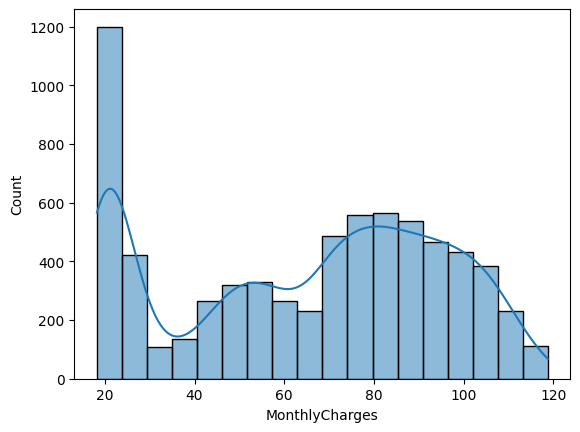

In [498]:
sns.histplot(df['MonthlyCharges'], kde=True)

<Axes: xlabel='MonthlyCharges', ylabel='Churn'>

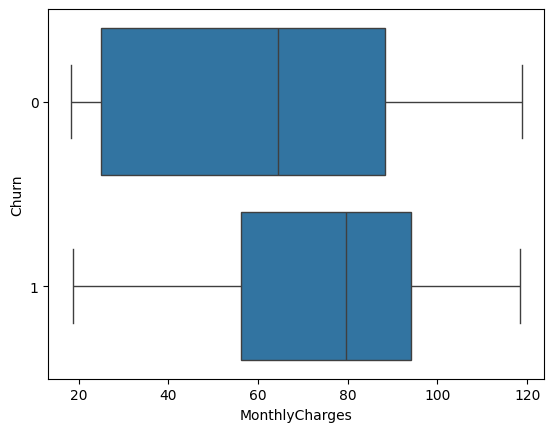

In [499]:
sns.boxplot(data=df, x='MonthlyCharges', y='Churn')

- The distribution seems to display 3 distinct groupings of monthly charges. This could be due to the number of services a customer subscribes to (phone, internet, or both).
- Users who churned had higher median monthly charges with less variation (smaller IQR).

**Total Charges Distribution**

<Axes: xlabel='TotalCharges', ylabel='Count'>

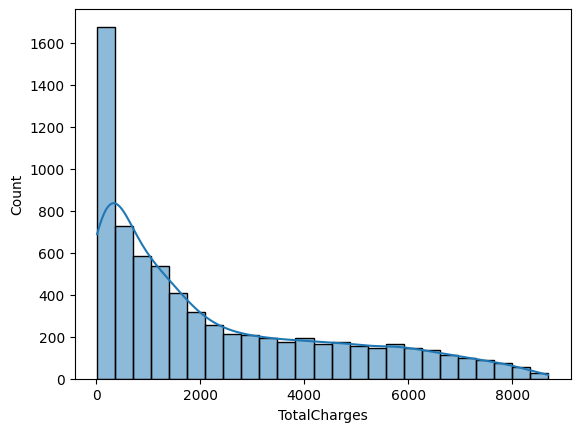

In [500]:
sns.histplot(df['TotalCharges'], kde=True)

<Axes: xlabel='TotalCharges', ylabel='Churn'>

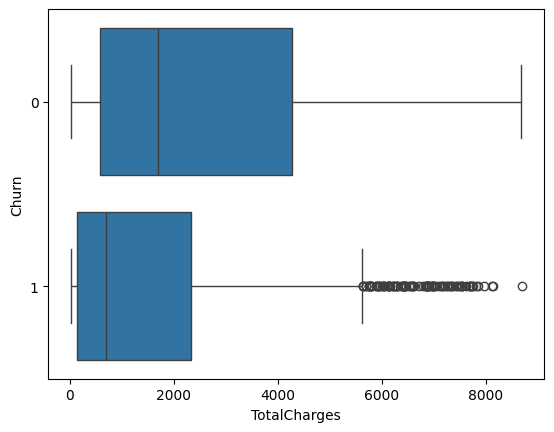

In [501]:
sns.boxplot(data=df, x='TotalCharges', y='Churn')

- The total charges distribution is skewed toward the right suggesting many outlier values.
- The median total charges for customers who churned is less than non churning customers, suggesting that customers who will churn do so after a relatively short period of time. In contrast there are a significant number of outliers. These outliers, however, do not exceed the upper bound for non-churn customers.

**Breakdown of Payment Method**

In [502]:
df['PaymentMethod'].value_counts(normalize=True)

PaymentMethod
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: proportion, dtype: float64

In [503]:
df.pivot_table(values='TotalCharges', index='PaymentMethod', columns='Churn', aggfunc='count')

Churn,0,1
PaymentMethod,,
Bank transfer (automatic),1286,258
Credit card (automatic),1290,232
Electronic check,1294,1071
Mailed check,1304,308


C:\Users\lette\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



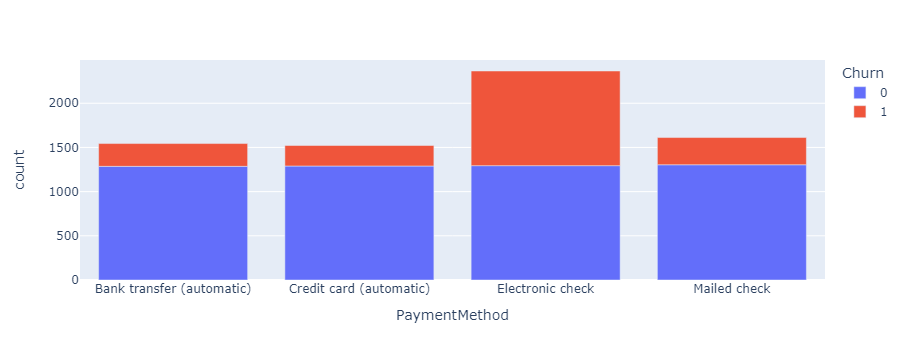

In [504]:
grouped_data = df.groupby(['PaymentMethod','Churn'], observed=True)['TotalCharges'].count().reset_index()
grouped_data = grouped_data.rename(columns={'PaymentMethod':'PaymentMethod','TotalCharges':'count'})
px.bar(grouped_data, x='PaymentMethod', y='count', color='Churn')

- For non-churn customers, payment methods are mostly evenly represented. For churn customers, paying with an electronic check was proportionally overrepresented.

**Breakdown of Contract Type**

In [505]:
df['Type'].value_counts(normalize=True)

Type
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: proportion, dtype: float64

In [506]:
df.pivot_table(values='TotalCharges', index='Type', columns='Churn', aggfunc='count')

Churn,0,1
Type,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


C:\Users\lette\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



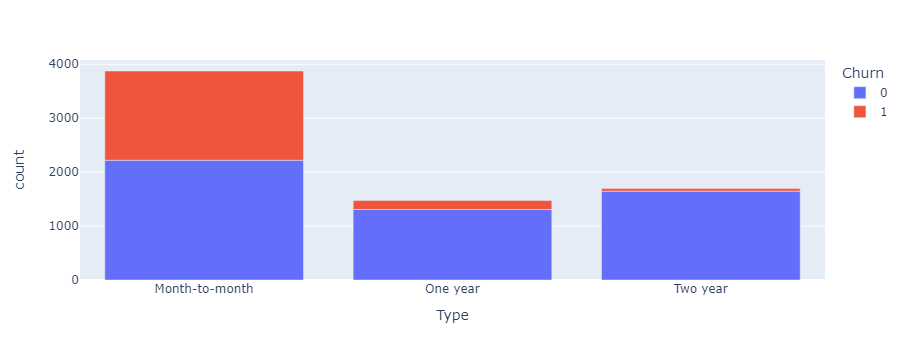

In [507]:
grouped_data = df.groupby(['Type','Churn'], observed=True)['TotalCharges'].count().reset_index()
grouped_data = grouped_data.rename(columns={'Type':'Type','TotalCharges':'count'})
px.bar(grouped_data, x='Type', y='count', color='Churn')

- Over half of customers selected a Month-to-month plan. Two year and one year plans almost split the remainder with two year plans being slightly more frequent than one year plans.
- Churn customers tended to choose the Month-to-month plan by a significantly larger proportion than non-churn customers.

**BeginDate of customers over time**

<Axes: xlabel='BeginDate'>

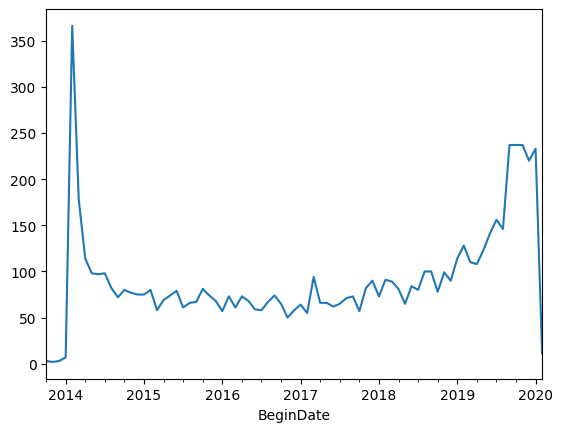

In [508]:
time_series = df.groupby('BeginDate')['TotalCharges'].count()
time_series.plot()

**AddedServices by Churn**

C:\Users\lette\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



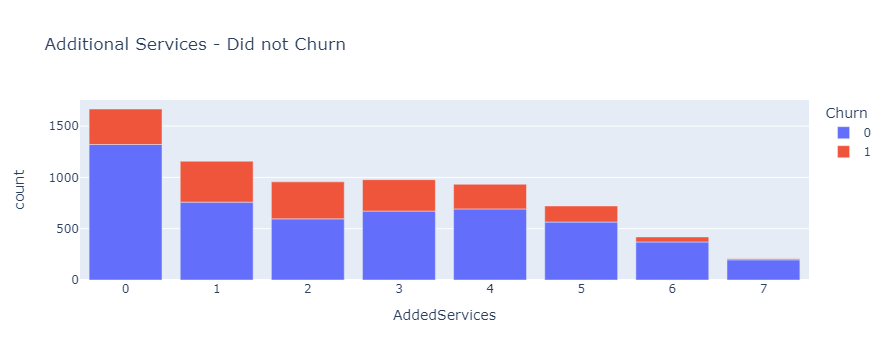

In [509]:
add_serv_count = df.groupby(['AddedServices','Churn'],observed=True)['TotalCharges'].count().reset_index()
add_serv_count.rename(columns={'TotalCharges':'count'},inplace=True)
px.bar(add_serv_count,x='AddedServices',y='count', color='Churn', title='Additional Services - Did not Churn')

# Step 5: Data Preparation

**Train Test Split**

In [510]:
X = df.drop(columns=['BeginDate', 'EndDate', 'Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

**Creating Preprocessor for Scaling and Encoding**
- The preprocessor scales numeric features and encodes categorical features for each train/validation split.

In [511]:
numeric_feat = ['MonthlyCharges','TotalCharges']

cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'BeginMonth', 'BeginYear', 'ServicesUsed',
       'AddedServices']

preprocessor = ColumnTransformer(transformers=[
    ('scaler',StandardScaler(),numeric_feat),
    ('cat',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_cols)
])

**Upsampling Train Set**

In [512]:
y_train.value_counts(normalize=True)

Churn
0    0.735534
1    0.264466
Name: proportion, dtype: float64

In [513]:
X_train, y_train = upsample(X_train, y_train, 3)

In [514]:
y_train.value_counts(normalize=True)

Churn
1    0.518923
0    0.481077
Name: proportion, dtype: float64

# Step 6: Machine Learning Modeling

**Dummy (constant) Classifier**

In [515]:
constant_model = DummyClassifier(strategy='constant', constant=0, random_state=12345)
constant_model.fit(X_train,y_train)

DummyClassifier(constant=0, random_state=12345, strategy='constant')

AUC - ROC Score: 0.5
Accuracy Score: 0.7310149041873669
Recall Score: 0.0
Precision Score: 0.0
F1 Score: 0.0
Confusion Matrix: [[1030    0]
 [ 379    0]]


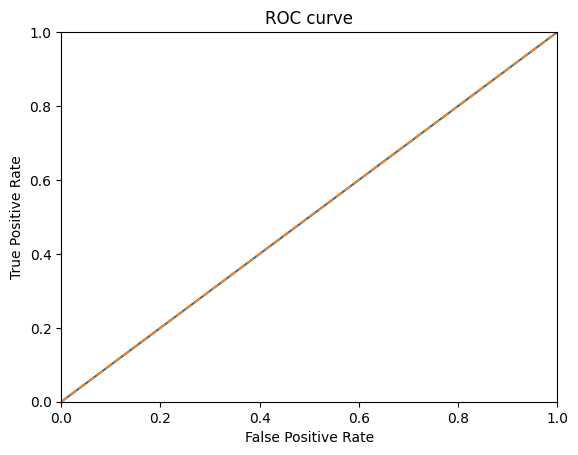

(0.5, 0.7310149041873669, 0.0)

In [516]:
const_metrics = evaluate_model(constant_model,X_test,y_test)
const_metrics

**Decision Tree Classifier**

In [517]:
tree_model = Pipeline(steps=[('preprocessing',preprocessor),('estimator',DecisionTreeClassifier(random_state=12345))])
cross_val = cross_validate(tree_model,X_train,y_train,scoring='roc_auc',return_train_score=True)
cross_val

{'fit_time': array([0.06408548, 0.05689335, 0.05881882, 0.05842733, 0.07697701]),
 'score_time': array([0.01171565, 0.01115513, 0.0122602 , 0.01190448, 0.02591157]),
 'test_score': array([0.91354304, 0.92405947, 0.9054938 , 0.92788676, 0.92465065]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [518]:
print(f'Average train roc-auc score: {cross_val["train_score"].mean():.3f}')
print(f'Average valid roc-auc score: {cross_val["test_score"].mean():.3f}')

Average train roc-auc score: 1.000
Average valid roc-auc score: 0.919


In [519]:
start = time.time()

tree_model = Pipeline(steps=[
    ('preprocessing',preprocessor),
    ('estimator',DecisionTreeClassifier(random_state=12345))
])

params = {
    'estimator__criterion':['gini','entropy'],
    'estimator__max_depth':[4,6,8,10],
    'estimator__min_samples_split':[2,5,10],
    'estimator__min_samples_leaf':[1,2,4]
}

grid = GridSearchCV(estimator=tree_model,param_grid=params,scoring='roc_auc')
grid.fit(X_train, y_train)
print(f'Best roc-auc score: {grid.best_score_:.3f} Best params: {grid.best_params_}')
tree_model = grid.best_estimator_

tree_train_time = np.round(time.time() - start, decimals=2)
print(f'Decision Tree Train Time: {tree_train_time}')

Best roc-auc score: 0.904 Best params: {'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2}
Decision Tree Train Time: 23.79


AUC - ROC Score: 0.85337628403822
Accuracy Score: 0.7920511000709723
Recall Score: 0.8021108179419525
Precision Score: 0.5823754789272031
F1 Score: 0.6748057713651499
Confusion Matrix: [[812 218]
 [ 75 304]]


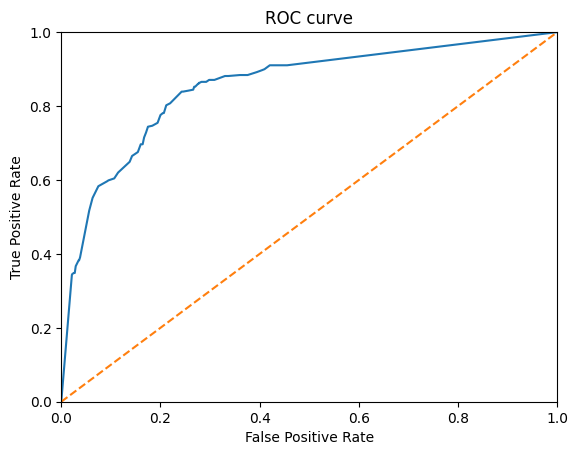

(0.85337628403822, 0.7920511000709723, 0.6748057713651499)

In [520]:
tree_metrics = evaluate_model(tree_model,X_test,y_test)
tree_metrics

**Gradient Boosting Classifier**

In [521]:
gb_model = Pipeline(steps=[('preprocessing',preprocessor),('estimator',GradientBoostingClassifier(random_state=12345))])
cross_val = cross_validate(gb_model,X_train,y_train,scoring='roc_auc',return_train_score=True)
cross_val

{'fit_time': array([0.90422273, 0.77088118, 0.76050472, 0.76347113, 0.78003812]),
 'score_time': array([0.01157117, 0.01167989, 0.01190209, 0.01296496, 0.01186872]),
 'test_score': array([0.89245891, 0.90413843, 0.90112208, 0.91103739, 0.9045502 ]),
 'train_score': array([0.92004127, 0.91834907, 0.91813055, 0.91755359, 0.92011501])}

In [522]:
print(f'Average train roc-auc score: {cross_val["train_score"].mean():.3f}')
print(f'Average valid roc-auc score: {cross_val["test_score"].mean():.3f}')

Average train roc-auc score: 0.919
Average valid roc-auc score: 0.903


In [523]:
start = time.time()

gb_model = Pipeline(steps=[('preprocessing',preprocessor),('estimator',GradientBoostingClassifier(random_state=12345))])

params = {
    'estimator__max_depth': [4, 6, 8],
    'estimator__n_estimators':[100,200,300],
    #'estimator__learning_rate': [0.1, 0.01, 0.001],
    #'estimator__subsample': [0.5, 0.7, 1]
}

grid = GridSearchCV(estimator=gb_model,param_grid=params,scoring='roc_auc')
grid.fit(X_train, y_train)
print(f'Best roc-auc score: {grid.best_score_:.3f} Best params: {grid.best_params_}')
gb_model = grid.best_estimator_

gb_train_time = np.round(time.time() - start, decimals=2)
print(f'Gradient Boosting Model Train Time: {gb_train_time}')

Best roc-auc score: 0.995 Best params: {'estimator__max_depth': 8, 'estimator__n_estimators': 300}
Gradient Boosting Model Train Time: 167.76


AUC - ROC Score: 0.9192688987370956
Accuracy Score: 0.872959545777147
Recall Score: 0.6886543535620053
Precision Score: 0.8105590062111802
F1 Score: 0.7446504992867332
Confusion Matrix: [[969  61]
 [118 261]]


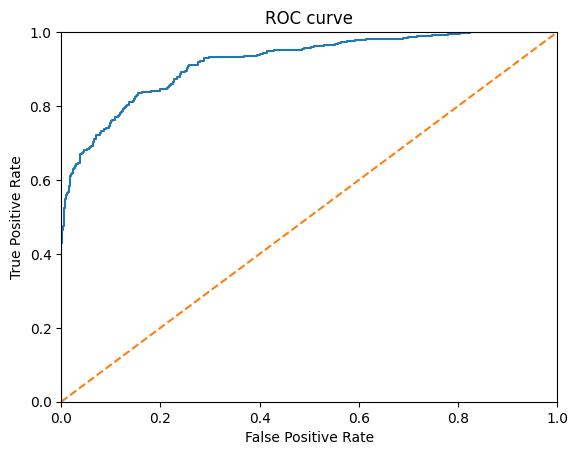

(0.9192688987370956, 0.872959545777147, 0.7446504992867332)

In [524]:
gb_metrics = evaluate_model(gb_model,X_test,y_test)
gb_metrics

**Light GBM Classifier**

In [525]:
lgbm_model = Pipeline(steps=[('preprocessing',preprocessor),('estimator',LGBMClassifier(random_state=12345))])
cross_val = cross_validate(lgbm_model,X_train,y_train,scoring='roc_auc',return_train_score=True)
cross_val

[LightGBM] [Info] Number of positive: 3576, number of negative: 3315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 6891, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518938 -> initscore=0.075787
[LightGBM] [Info] Start training from score 0.075787
[LightGBM] [Info] Number of positive: 3576, number of negative: 3315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 6891, number of used features: 21
[LightGBM] [Info] [binary:Bo

{'fit_time': array([0.15448594, 0.16371298, 0.17200422, 0.17271423, 0.16023207]),
 'score_time': array([0.02830863, 0.02848577, 0.0283165 , 0.02022076, 0.02223659]),
 'test_score': array([0.95658498, 0.9674185 , 0.96305621, 0.96784083, 0.96659561]),
 'train_score': array([0.99133143, 0.99090366, 0.99147821, 0.99199456, 0.99148525])}

In [526]:
print(f'Average train roc-auc score: {cross_val["train_score"].mean():.3f}')
print(f'Average valid roc-auc score: {cross_val["test_score"].mean():.3f}')

Average train roc-auc score: 0.991
Average valid roc-auc score: 0.964


In [527]:
start = time.time()

lgbm_model = Pipeline(steps=[('preprocessing',preprocessor),('estimator',LGBMClassifier(random_state=12345))])

params = {
    'estimator__max_depth': [4, 6, 8],
    'estimator__n_estimators':[100,200,300],
    #'estimator__learning_rate': [0.1, 0.01, 0.001],
    #'estimator__subsample': [0.5, 0.7, 1]
}

grid = GridSearchCV(lgbm_model, params, scoring='roc_auc')
grid.fit(X_train, y_train)
print(f'Best roc-auc score: {grid.best_score_:.3f} Best params: {grid.best_params_}')
lgbm_model = grid.best_estimator_

lgbm_train_time = np.round(time.time() - start, decimals=2)
print(f'LGBM Model Train Time: {lgbm_train_time}')

[LightGBM] [Info] Number of positive: 3576, number of negative: 3315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 6891, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518938 -> initscore=0.075787
[LightGBM] [Info] Start training from score 0.075787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

AUC - ROC Score: 0.9224889207674769
Accuracy Score: 0.8786373314407381
Recall Score: 0.7493403693931399
Precision Score: 0.7888888888888889
F1 Score: 0.7686062246278755
Confusion Matrix: [[954  76]
 [ 95 284]]


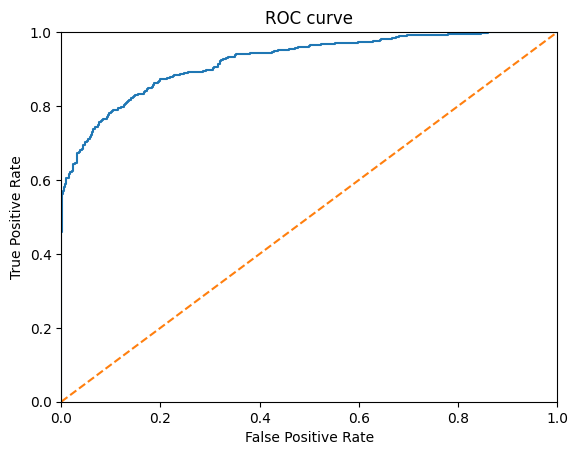

(0.9224889207674769, 0.8786373314407381, 0.7686062246278755)

In [528]:
lgbm_metrics = evaluate_model(lgbm_model,X_test,y_test)
lgbm_metrics

# Conclusion

In [529]:
print(f'Decision Tree Model: roc-auc {tree_metrics[0]:.3f}, accuracy {tree_metrics[1]:.3f}, f1 {tree_metrics[2]:.3f}, time {tree_train_time}')
print(f'Gradient Boosting Model: roc-auc {gb_metrics[0]:.3f}, accuracy {gb_metrics[1]:.3f}, f1 {gb_metrics[2]:.3f}, time {gb_train_time}')
print(f'LightGBM Model: roc-auc {lgbm_metrics[0]:.3f}, accuracy {lgbm_metrics[1]:.3f}, f1 {lgbm_metrics[2]:.3f}, time {lgbm_train_time}')
print(f'Constant Model: roc-auc {const_metrics[0]:.3f}, accuracy {const_metrics[1]:.3f}, f1 {const_metrics[2]:.3f}')

Decision Tree Model: roc-auc 0.853, accuracy 0.792, f1 0.675, time 23.79
Gradient Boosting Model: roc-auc 0.919, accuracy 0.873, f1 0.745, time 167.76
LightGBM Model: roc-auc 0.922, accuracy 0.879, f1 0.769, time 11.8
Constant Model: roc-auc 0.500, accuracy 0.731, f1 0.000


Since the LightGBM model received the best roc-auc, accuracy and f1 scores and was comparably fast, I recommend that this model be used to carry out churn classification.